In [2]:
from wfdb import io, processing, plot, Record
import choose_10_random_subjects
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from process_10_seconds_signal import ecg_10
from process_120_seconds_signal import ecg_120
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
import random
from imblearn.over_sampling import SMOTE
from collections import Counter
import math

In [4]:
index=1
pathList=[
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient248/s0481_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient266/s0502_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient242/s0471_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient233/s0457_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient239/s0467_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient229/s0453_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient263/s0499_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient247/s0479_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient238/s0466_re',
    '/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient246/s0478_re'
]

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient248/s0481_re


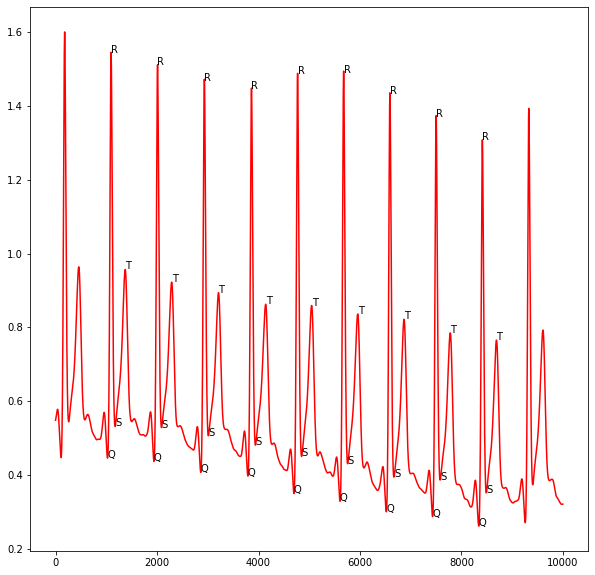

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient266/s0502_re


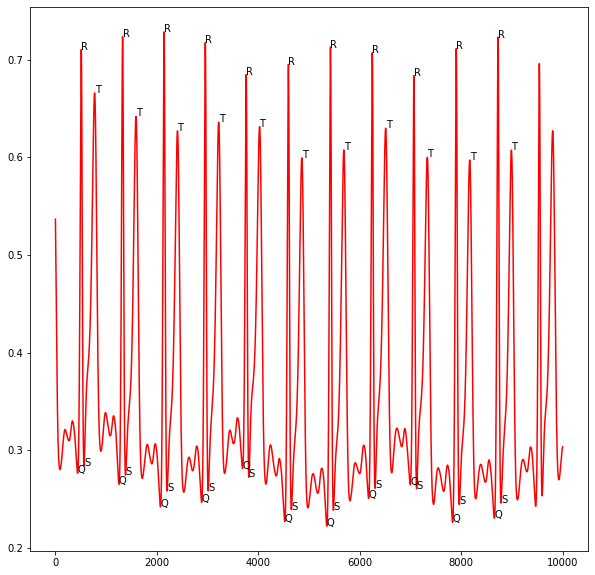

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient242/s0471_re


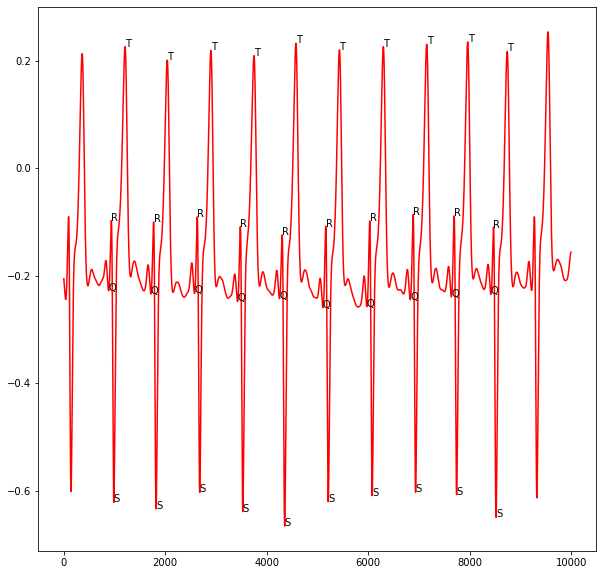

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient233/s0457_re


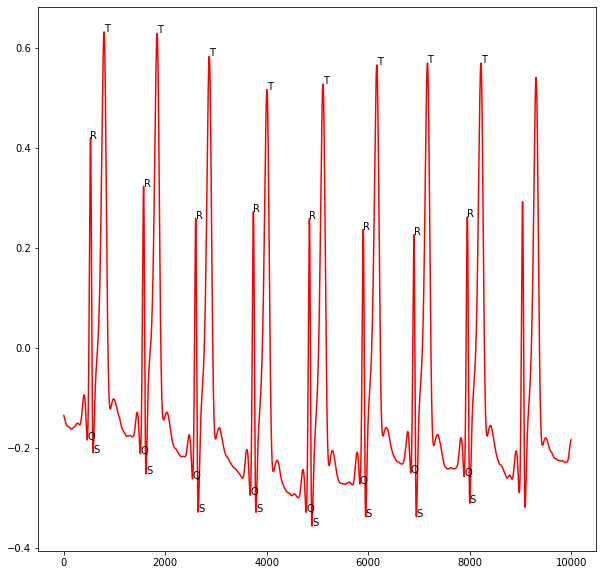

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient239/s0467_re


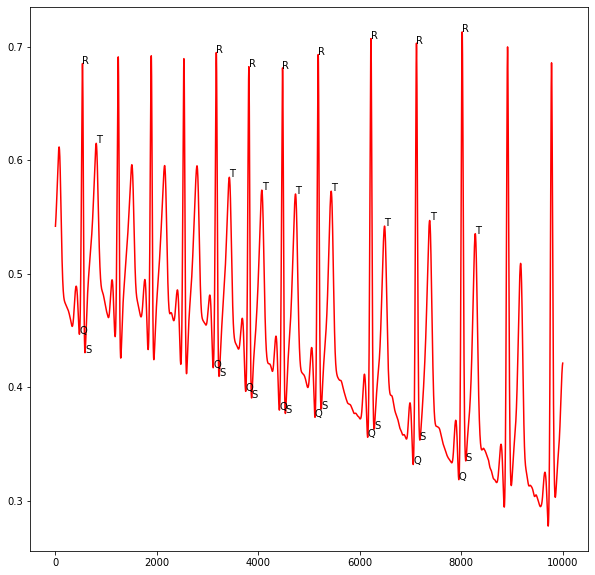

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient229/s0453_re


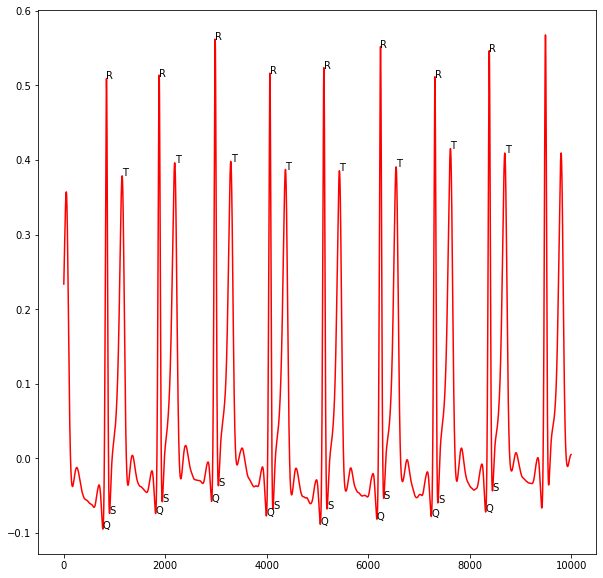

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient263/s0499_re


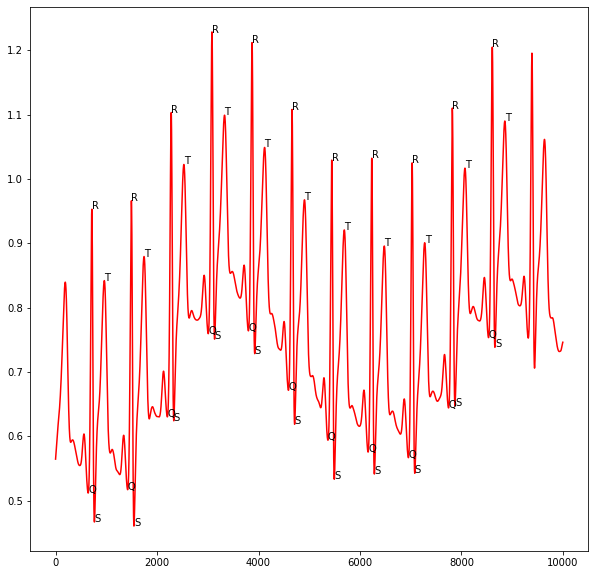

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient247/s0479_re


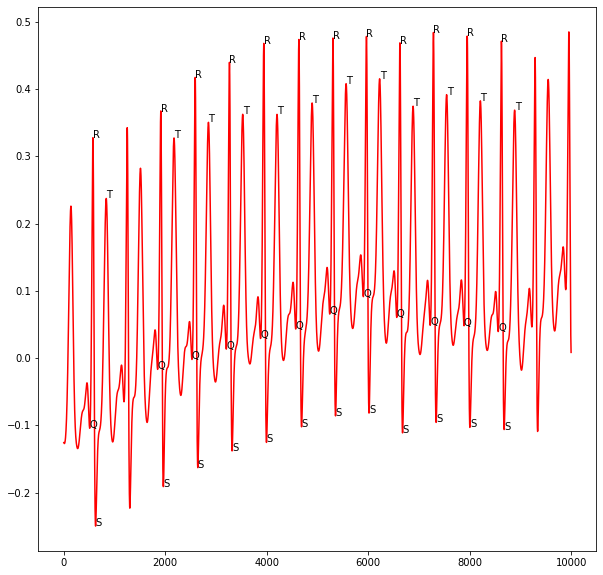

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient238/s0466_re


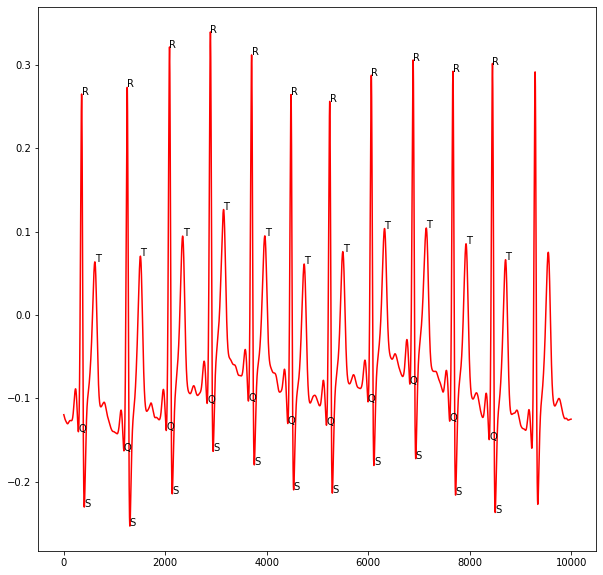

/home/adriangotca/Bachelor Thesis/ptbdb-1.0.0.physionet.org/patient246/s0478_re


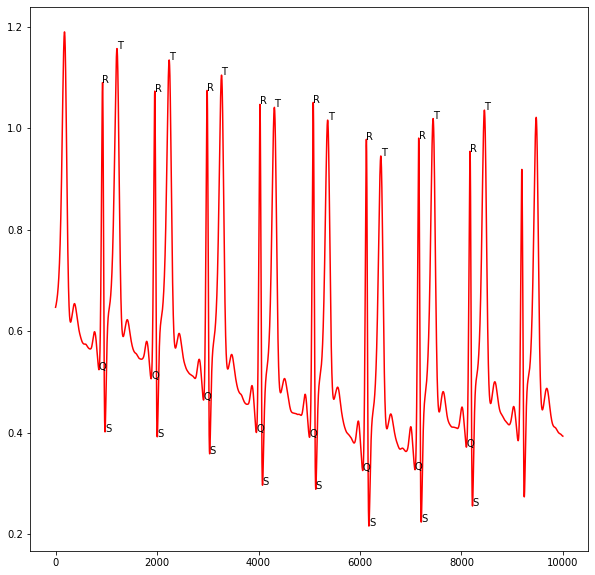

In [8]:
#########################################Preprocesare pentru solutia 1#############################################

ecgList=[]
for subject in pathList:
    print(subject)
    ecg = ecg_120(subject, plot=True)
    ecgList.append(ecg)
    index+=1

In [ ]:
####################################Preprocesare pentru solutia 2,3,4,5#############################################

ecgList=[]
for subject in pathList:
    print(subject)
    ecg = ecg_120(subject, plot=True, qtc_filter=True)
    ecgList.append(ecg)
    index+=1

In [6]:
#################################################SOLUTIA 1##########################################################

for ecgIndex1 in range(len(ecgList)):
    segs = ecgList[ecgIndex1].segments
    runs=[]
    for segmentIndex1 in range(len(segs)):
        for segmentIndex2 in range(segmentIndex1+1,len(segs)):
            nr=0
            rr=0
            correctGuessesForThisOne=0
            numberOfGuessesForThisOne=0
            avg_rr=0
            X_train=[]
            X_test=[]
            Y_train=[]
            Y_test=[]
            for ecgIndex2 in range(len(ecgList)):
                for segmentIndex3 in range(len(segs)):
                    lastR=0
                    lastIndex=0
                    if ecgIndex1==ecgIndex2 and (segmentIndex3==segmentIndex1 or segmentIndex3==segmentIndex2):
                        continue
                    for (R,index) in zip(ecgList[ecgIndex2].segments[segmentIndex3]["R"],ecgList[ecgIndex2].segments[segmentIndex3]["i"]):
                        if lastR==0:
                            lastR=R
                            lastIndex=index
                            continue
                        rr+=R-lastR
                        nr+=index-lastIndex
                        lastR=R
                        lastIndex=index
            avg_rr=rr/nr
            for ecgIndex2 in range(len(ecgList)):
                for segmentIndex3 in range(len(segs)):
                    for (Q,R,S,T) in zip(segs[segmentIndex3]["Q"],segs[segmentIndex3]["R"],segs[segmentIndex3]["S"],segs[segmentIndex3]["T"]):
                        QT = (T-Q)/avg_rr
                        RT = (T-R)/avg_rr
                        ST = (T-S)/avg_rr
                        if ecgIndex1!=ecgIndex2:
                            X_train.append([QT,RT,ST])
                            Y_train.append(0)
                        else:
                            if segmentIndex3==segmentIndex1 or segmentIndex3==segmentIndex2:
                                X_test.append([QT,RT,ST])
                                Y_test.append(1)
                            else:
                                X_train.append([QT,RT,ST])
                                Y_train.append(1)
            X_train = np.array(X_train)
            Y_train = np.array(Y_train)
            X_test = np.array(X_test)
            Y_test = np.array(Y_test)
            C_range=[0.001,0.01,0.1,1,5,10,100]
            gamma_range=[0.001,0.01,0.1,1,5,10,100]
            param_grid = dict(gamma=gamma_range, C=C_range, class_weight=['balanced'])
            grid = GridSearchCV(SVC(), param_grid=param_grid)
            grid.fit(X_train, Y_train)
            svm = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], class_weight='balanced')
            svm.fit(X_train,Y_train)
            results = svm.predict(X_test)
            for result in results:
                numberOfGuessesForThisOne+=1
                correctGuessesForThisOne+=result
            runs.append(correctGuessesForThisOne/numberOfGuessesForThisOne)
    maxim=0
    minim=1
    s=0
    std_dev=0
    for run in runs:
        s+=run
        maxim=max(maxim,run)
        minim=min(minim,run)
    avg=s/len(runs)
    for run in runs:
        std_dev+=(run-avg)**2
    std_dev/=len(runs)
    std_dev=math.sqrt(std_dev)
    print("FOR "+str(ecgIndex1)+": ")
    print("OVERALL SCORE: "+str(avg))
    print("MINIMUM: "+str(minim))
    print("MAXIMUM: "+str(maxim))
    print("STANDARD DEVIATION: "+str(std_dev))

FOR 0: 
OVERALL SCORE: 0.0
MINIMUM: 0.0
MAXIMUM: 0
STANDARD DEVIATION: 0.0
FOR 1: 
OVERALL SCORE: 0.8560606060606061
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.32534088283046264
FOR 2: 
OVERALL SCORE: 1.0
MINIMUM: 1
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0
FOR 3: 
OVERALL SCORE: 0.5757575757575758
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.49422746758485114
FOR 4: 
OVERALL SCORE: 0.48217468805704095
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.4898272798380836
FOR 5: 
OVERALL SCORE: 0.2958532695374801
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.4522684229443939
FOR 6: 
OVERALL SCORE: 0.696969696969697
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.45956820873039717
FOR 7: 
OVERALL SCORE: 0.3787878787878788
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.4850851695024889
FOR 8: 
OVERALL SCORE: 0.4861989459815547
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.4572084508946561
FOR 9: 
OVERALL SCORE: 0.26515151515151514
MINIMUM: 0.0
MAXIMUM: 0.625
STANDARD DEVIATION: 0.19002

In [11]:
#################################################SOLUTIA 2##########################################################

for ecgIndex1 in range(len(ecgList)):
    segs = ecgList[ecgIndex1].segments
    runs=[]
    for segmentIndex1 in range(len(segs)):
        for segmentIndex2 in range(segmentIndex1+1,len(segs)):
            nr=0
            rr=0
            correctGuessesForThisOne=0
            numberOfGuessesForThisOne=0
            avg_rr=0
            X_train=[]
            X_test=[]
            Y_train=[]
            Y_test=[]
            for ecgIndex2 in range(len(ecgList)):
                for segmentIndex3 in range(len(segs)):
                    lastR=0
                    lastIndex=0
                    if ecgIndex1==ecgIndex2 and (segmentIndex3==segmentIndex1 or segmentIndex3==segmentIndex2):
                        continue
                    for (R,index) in zip(ecgList[ecgIndex2].segments[segmentIndex3]["R"],ecgList[ecgIndex2].segments[segmentIndex3]["i"]):
                        if lastR==0:
                            lastR=R
                            lastIndex=index
                            continue
                        rr+=R-lastR
                        nr+=index-lastIndex
                        lastR=R
                        lastIndex=index
            avg_rr=rr/nr
            for ecgIndex2 in range(len(ecgList)):
                for segmentIndex3 in range(len(segs)):
                    for (Q,R,S,T) in zip(segs[segmentIndex3]["Q"],segs[segmentIndex3]["R"],segs[segmentIndex3]["S"],segs[segmentIndex3]["T"]):
                        QT = (T-Q)/avg_rr
                        RT = (T-R)/avg_rr
                        ST = (T-S)/avg_rr
                        if ecgIndex1!=ecgIndex2:
                            X_train.append([QT,RT,ST])
                            Y_train.append(0)
                        else:
                            if segmentIndex3==segmentIndex1 or segmentIndex3==segmentIndex2:
                                X_test.append([QT,RT,ST])
                                Y_test.append(1)
                            else:
                                X_train.append([QT,RT,ST])
                                Y_train.append(1)
            X_train = np.array(X_train)
            Y_train = np.array(Y_train)
            X_test = np.array(X_test)
            Y_test = np.array(Y_test)
            C_range=[0.001,0.01,0.1,1,5,10,100]
            gamma_range=[0.001,0.01,0.1,1,5,10,100]
            param_grid = dict(gamma=gamma_range, C=C_range, class_weight=['balanced'])
            grid = GridSearchCV(SVC(), param_grid=param_grid)
            grid.fit(X_train, Y_train)
            svm = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], class_weight='balanced')
            svm.fit(X_train,Y_train)
            results = svm.predict(X_test)
            for result in results:
                numberOfGuessesForThisOne+=1
                correctGuessesForThisOne+=result
            runs.append(correctGuessesForThisOne/numberOfGuessesForThisOne)
    maxim=0
    minim=1
    s=0
    std_dev=0
    for run in runs:
        s+=run
        maxim=max(maxim,run)
        minim=min(minim,run)
    avg=s/len(runs)
    for run in runs:
        std_dev+=(run-avg)**2
    std_dev/=len(runs)
    std_dev=math.sqrt(std_dev)
    print("FOR "+str(ecgIndex1)+": ")
    print("OVERALL SCORE: "+str(avg))
    print("MINIMUM: "+str(minim))
    print("MAXIMUM: "+str(maxim))
    print("STANDARD DEVIATION: "+str(std_dev))

FOR 0: 
OVERALL SCORE: 0.0
MINIMUM: 0.0
MAXIMUM: 0
STANDARD DEVIATION: 0.0
FOR 1: 
OVERALL SCORE: 0.8560606060606061
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.32534088283046264
FOR 2: 
OVERALL SCORE: 1.0
MINIMUM: 1
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0
FOR 3: 
OVERALL SCORE: 0.5757575757575758
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.49422746758485114
FOR 4: 
OVERALL SCORE: 0.48217468805704095
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.4898272798380836
FOR 5: 
OVERALL SCORE: 0.2958532695374801
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.4522684229443939
FOR 6: 
OVERALL SCORE: 0.696969696969697
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.45956820873039717
FOR 7: 
OVERALL SCORE: 0.3787878787878788
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.4850851695024889
FOR 8: 
OVERALL SCORE: 0.4861989459815547
MINIMUM: 0.0
MAXIMUM: 1.0
STANDARD DEVIATION: 0.4572084508946561
FOR 9: 
OVERALL SCORE: 0.26515151515151514
MINIMUM: 0.0
MAXIMUM: 0.625
STANDARD DEVIATION: 0.19002

In [33]:
#################################################SOLUTIA 3##########################################################

X=[[] for _ in range(len(ecgList))]
for ecgIndex in range(len(ecgList)):
    for segment in ecgList[ecgIndex].segments:
        for (Q,R,S,T) in zip(segment["Q"],segment["R"],segment["S"],segment["T"]):
            X[ecgIndex].append([T-Q,T-R,T-S])
runs=[]
for i in range(100):
    index=0
    X_train, X_test, Y_train, Y_test=[],[],[],[]
    for X_ in X:
        Y_=[index for _ in X_]
        X_tr, X_te, Y_tr, Y_te = train_test_split(X_, Y_, test_size=0.2)
        for (x_tr, x_te, y_tr, y_te) in zip(X_tr,X_te,Y_tr,Y_te):
            X_train.append(x_tr)
            X_test.append(x_te)
            Y_train.append(y_tr)
            Y_test.append(y_te)
        index+=1
    
    pipe = Pipeline([('scaler',StandardScaler()),('clf',LinearSVC())])
    param_grid=dict(
        clf__C=[0.001,0.01,0.1,1,5,10,100],
        clf__class_weight=['balanced']
    )
    X_train, Y_train, X_test, Y_test = np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)
    grid_search=GridSearchCV(pipe, param_grid=param_grid)
    grid_search.fit(X_train, Y_train)
    pipe.set_params(clf__C=grid_search.best_params_['clf__C'],clf__class_weight=grid_search.best_params_['clf__class_weight'],clf__max_iter=1000000)
    pipe.fit(X_train, Y_train)
    runs.append(pipe.score(X_test,Y_test))
maxim=0
minim=1
s=0
std_dev=0
for run in runs:
    s+=run
    maxim=max(maxim,run)
    minim=min(minim,run)
avg=s/len(runs)
for run in runs:
    std_dev+=(run-avg)**2
std_dev/=len(runs)
std_dev=math.sqrt(std_dev)
print("OVERALL SCORE: "+str(avg))
print("MINIMUM: "+str(minim))
print("MAXIMUM: "+str(maxim))
print("STANDARD DEVIATION: "+str(std_dev))

/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear fai

/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear fai

/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/adriangotca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


KeyboardInterrupt: 

In [23]:
#################################################SOLUTIA 4##########################################################

for ecgIndex1 in range(len(ecgList)):
    numberOfRuns=0
    sumOfRuns=0
    X0=[]
    X1=[]
    Y0=[]
    Y1=[]
    for ecgIndex2 in range(len(ecgList)):
        for segment in ecgList[ecgIndex2].segments:
            for (Q,R,S,T) in zip(segment["Q"],segment["R"],segment["S"],segment["T"]):
                if ecgIndex2==ecgIndex1:
                    X1.append([T-Q,T-R,T-S])
                    Y1.append(1)
                else:
                    X0.append([T-Q,T-R,T-S])
                    Y0.append(0)
    X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1,test_size=0.2)
    X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0,Y0,test_size=0.2)
    X_train=[]
    X_test=[]
    Y_train=[]
    Y_test=[]
    for _ in X1_train:
        X_train.append(_)
    for _ in X0_train:
        X_train.append(_)
    for _ in X1_test:
        X_test.append(_)
    for _ in X0_test:
        X_test.append(_)
    for _ in Y1_train:
        Y_train.append(_)
    for _ in Y0_train:
        Y_train.append(_)
    for _ in Y1_test:
        Y_test.append(_)
    for _ in Y0_test:
        Y_test.append(_)
    X_train, X_test, Y_train, Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)
    pipe = Pipeline([('normalizer',Normalizer()),('clf',SVC())])
    param_grid=dict(
        clf__C=[0.001,0.01,0.1,1,5,10,100],
        clf__gamma=[0.001,0.01,0.1,1,5,10,100],
        clf__class_weight=['balanced']
    )
    grid_search=GridSearchCV(pipe, param_grid=param_grid)
    grid_search.fit(X_train, Y_train)
    pipe.set_params(clf__C=grid_search.best_params_['clf__C'],clf__gamma=grid_search.best_params_['clf__gamma'],clf__class_weight=grid_search.best_params_['clf__class_weight'])
    runs=[]
    for i in range(100):
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
        pipe.fit(X_train, Y_train)
        runs.append(pipe.score(X_test,Y_test))
    maxim=0
    minim=1
    s=0
    std_dev=0
    for run in runs:
        s+=run
        maxim=max(maxim,run)
        minim=min(minim,run)
    avg=s/len(runs)
    for run in runs:
        std_dev+=(run-avg)**2
    std_dev/=len(runs)
    std_dev=math.sqrt(std_dev)
    print("FOR "+str(ecgIndex1)+": ")
    print("OVERALL SCORE: "+str(avg))
    print("MINIMUM: "+str(minim))
    print("MAXIMUM: "+str(maxim))
    print("STANDARD DEVIATION: "+str(std_dev))

FOR 0: 
OVERALL SCORE: 1.0
MINIMUM: 1
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0
FOR 1: 
OVERALL SCORE: 1.0
MINIMUM: 1
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0
FOR 2: 
OVERALL SCORE: 0.9734349593495939
MINIMUM: 0.9613821138211383
MAXIMUM: 0.9857723577235772
STANDARD DEVIATION: 0.0058291534839188955
FOR 3: 
OVERALL SCORE: 0.4988211382113819
MINIMUM: 0.45528455284552843
MAXIMUM: 0.5426829268292683
STANDARD DEVIATION: 0.018459447616127375
FOR 4: 
OVERALL SCORE: 0.9875609756097552
MINIMUM: 0.9735772357723578
MAXIMUM: 0.9959349593495935
STANDARD DEVIATION: 0.004399643656064698
FOR 5: 
OVERALL SCORE: 1.0
MINIMUM: 1
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0
FOR 6: 
OVERALL SCORE: 1.0
MINIMUM: 1
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0
FOR 7: 
OVERALL SCORE: 1.0
MINIMUM: 1
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0
FOR 8: 
OVERALL SCORE: 0.5008739837398373
MINIMUM: 0.44715447154471544
MAXIMUM: 0.5630081300813008
STANDARD DEVIATION: 0.020768051595734388
FOR 9: 
OVERALL SCORE: 1.0
MINIMUM: 1
MAXIMUM: 1.0
STANDARD DEVIAT

In [20]:
#################################################SOLUTIA 5##########################################################

for ecgIndex1 in range(len(ecgList)):
    numberOfRuns=0
    sumOfRuns=0
    X0=[]
    X1=[]
    X=[]
    Y=[]
    for ecgIndex2 in range(len(ecgList)):
        for segment in ecgList[ecgIndex2].segments:
            for (Q,R,S,T) in zip(segment["Q"],segment["R"],segment["S"],segment["T"]):
                if ecgIndex2==ecgIndex1:
                    X1.append([T-Q,T-R,T-S])
                else:
                    X0.append([T-Q,T-R,T-S])
    index=0
    for _ in X1:
        X.append(_)
        Y.append(1)
    for _ in X0:
        X.append(_)
        Y.append(0)
    sampler = SMOTE()
    X=np.array(X)
    Y=np.array(Y)
    X,Y = sampler.fit_resample(X,Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=0)
    pipe = Pipeline([('normalizer',Normalizer()),('clf',SVC())])
    param_grid=dict(
        clf__C=[0.001,0.01,0.1,1,5,10,100],
        clf__gamma=[0.001,0.01,0.1,1,5,10,100]
    )
    grid_search=GridSearchCV(pipe, param_grid=param_grid)
    grid_search.fit(X_train, Y_train)
    pipe.set_params(clf__C=grid_search.best_params_['clf__C'],clf__gamma=grid_search.best_params_['clf__gamma'])
    runs=[]
    for i in range(100):
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
        pipe.fit(X_train, Y_train)
        runs.append(pipe.score(X_test,Y_test))
    maxim=0
    minim=1
    s=0
    std_dev=0
    for run in runs:
        s+=run
        maxim=max(maxim,run)
        minim=min(minim,run)
    avg=s/len(runs)
    for run in runs:
        std_dev+=(run-avg)**2
    std_dev/=len(runs)
    std_dev=math.sqrt(std_dev)
    print("FOR "+str(ecgIndex1)+": ")
    print("OVERALL SCORE: "+str(avg))
    print("MINIMUM: "+str(minim))
    print("MAXIMUM: "+str(maxim))
    print("STANDARD DEVIATION: "+str(std_dev))

FOR 0: 
OVERALL SCORE: 0.9800204918032785
MINIMUM: 0.9631147540983607
MAXIMUM: 0.9938524590163934
STANDARD DEVIATION: 0.00576235192239298
FOR 1: 
OVERALL SCORE: 0.9773486430062627
MINIMUM: 0.9561586638830898
MAXIMUM: 0.9916492693110647
STANDARD DEVIATION: 0.006031741216364789
FOR 2: 
OVERALL SCORE: 0.9995416666666668
MINIMUM: 0.9958333333333333
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0009119195261766346
FOR 3: 
OVERALL SCORE: 0.9292668024439925
MINIMUM: 0.9063136456211812
MAXIMUM: 0.9592668024439919
STANDARD DEVIATION: 0.009985263800946538
FOR 4: 
OVERALL SCORE: 0.8609894736842112
MINIMUM: 0.8294736842105264
MAXIMUM: 0.9073684210526316
STANDARD DEVIATION: 0.01504476791284088
FOR 5: 
OVERALL SCORE: 0.9567827868852454
MINIMUM: 0.930327868852459
MAXIMUM: 0.9774590163934426
STANDARD DEVIATION: 0.009255832469042125
FOR 6: 
OVERALL SCORE: 0.9990775681341713
MINIMUM: 0.9958071278825996
MAXIMUM: 1.0
STANDARD DEVIATION: 0.0012338732888521797
FOR 7: 
OVERALL SCORE: 0.8496405919661728
MINIMUM: 0.80549